# Python Interface
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rl-tools/documentation/blob/master/docs/09-Python%20Interface.ipynb)

For ease of use we provide a Python bindings for RLtools that can simply be installed by `pip install rltools`. It uses `pybind11` which is its only necessary dependency. Since one of the main premises of RLtools is that the size of all data structures and loops is known at compile-time, we can not compile the RLtools interface ahead of time. This issue arises for example with the observation and action dimensionality, which are dependent on the environment and, by the nature of Python, are only known at run-time. Hence we compile the RLtools interface just-in-time, when an RL algorithm is instantiated for a concrete environment.

The RLtools Python interface also supports accelerated backends (e.g. Apple Accelerate and Intel MKL). Apple Accelerate is detected automatically and does not require additional actions, while Intel MKL can be installed using the `rltools[mkl]` option as can be seen in the following:

In [1]:
!pip install rltools[mkl] gymnasium > /dev/null # ignoring the output to keep this notebook concise

Note: On macOS remove the `[mkl]`, the Apple Accelerate backend will be used automatically.

The RLtools Python interface is compatible with Gym/Gymnasium environments that have continuous actions. In the following we show the training of the pendulum swing-up using SAC as an example:

In [2]:
from rltools import SAC
import gymnasium as gym
from gymnasium.experimental.wrappers import RescaleActionV0

seed=0xf00d
environment_name = "Pendulum-v1"

### Training
Since the RL algorithms in RLtools might create multiple instances of the environment (e.g. for vectorized simulation) we create a factory method that creates an instance of the desired environment and hand it over to the `SAC` function that has been imported from tinyrl. The `SAC` function compiles the RLtools interface and takes a [plethora of options](https://github.com/rl-tools/tinyrl/blob/fdc2b19e896543a437fd859fb7eceed2550b975a/tinyrl/src/sac.py#L14). It returns the compiled module which contains a wrapper for [the SAC training loop state data structure](https://github.com/rl-tools/rl-tools/blob/master/include/rl_tools/rl/algorithms/sac/loop/core/state.h). Once the training state is instantiated, the training can be progressed step-by-step like described in [The Loop Interface](./07-The%20Loop%20Interface.ipynb).

In [3]:
def env_factory():
    env = gym.make(environment_name)
    env = RescaleActionV0(env, -1, 1)
    env.reset(seed=seed)
    return env
sac = SAC(env_factory)
state = sac.State(seed)
finished = False
while not finished:
    finished = state.step()

MKL found. Version: 2024.1.0 (include: 2024.1.0, path /opt/conda/lib/python3.12/site-packages/../../../include)
Using cached RLtools interface.
Step: 0/10000 Mean return: -1187.51
Step: 1000/10000 Mean return: -1671.65
Step: 2000/10000 Mean return: -900.844
Step: 3000/10000 Mean return: -129.982
Step: 4000/10000 Mean return: -129.417
Step: 5000/10000 Mean return: -706.237
Step: 6000/10000 Mean return: -1196.63
Step: 7000/10000 Mean return: -1209.53
Step: 8000/10000 Mean return: -1560.66
Step: 9000/10000 Mean return: -129.01
Time: 3.203s


### Inference
To show the behavior of the policy we install some utilities for rendering:

In [4]:
!pip install gymnasium\[classic-control\] imageio > /dev/null

Now we can instantiate an environment as usual:

In [5]:
import imageio, io
from IPython.display import Image, display

env = gym.make('Pendulum-v1', render_mode='rgb_array')
env.reset(seed=seed) and None

You can evaluate the policy using `action = state.action(observation)` (also during the training to, e.g., assess the performance at different stages). In the following, we execute the rollout of one episode and generate an animation (you can execute the cell again to sample a new roll-out):

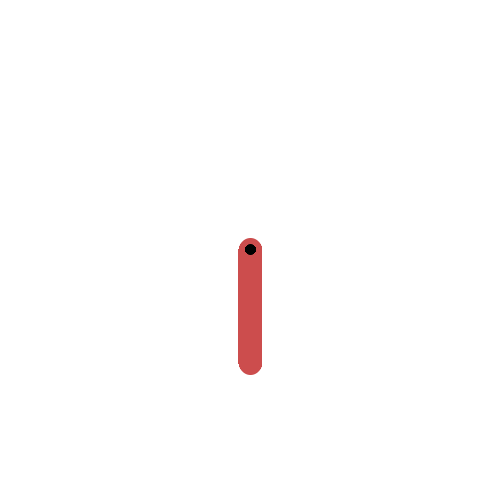

In [6]:
import numpy as np
def evaluate(policy):
    frames = []
    env.reset()
    env.env.env.env.state = np.array([np.pi, 0]) # to start all the way down for a better animation
    observation, _, _, _, _ = env.step(np.array([0]))
    finished = False
    while not finished:
      frames.append(env.render())
      action = state.action(observation)
      observation, reward, terminated, truncated, _ = env.step(action)
      finished = terminated or truncated
    gif_io = io.BytesIO()
    imageio.mimsave(gif_io, frames, format="GIF", fps=1/env.env.env.env.dt, loop=0)
    gif_io.seek(0)
    display(Image(data=gif_io.read(), format='png'))

evaluate(lambda observation: state.action(observation))

### Exporting the Trained Policy
The trained policy can be exported as a `.h` file so that it can e.g. be compiled into the firmware of a microcontroller

In [7]:
with open("checkpoint.h", "w") as f:
    f.write(state.export_policy())

You can view the [checkpoint](./checkpoint.h) to get a feeling on how this works. In short, the floating point values of the weights and biases of all layers are converted to unsigned 8-bit integers so that the exact bit-values (according to the [IEEE 754](https://en.wikipedia.org/wiki/IEEE_754) are stored and there is no loss of precision between exporting and importing. This exported header file can be easily integrated into C/C++ projects of any kind (e.g. [ones targeting Microcontrollers](https://github.com/arplaboratory/learning_to_fly_controller/blob/af669f62e16f0ee4ef9d7a7fa4925c44ef71560a/rl_tools_adapter.cpp#L9) or WebAssembly). 

Using the Python interface, we can easily import back a checkpoint and make it accessible to Python as well:

MKL found. Version: 2024.1.0 (include: 2024.1.0, path /opt/conda/lib/python3.12/site-packages/../../../include)
Using cached RLtools interface.


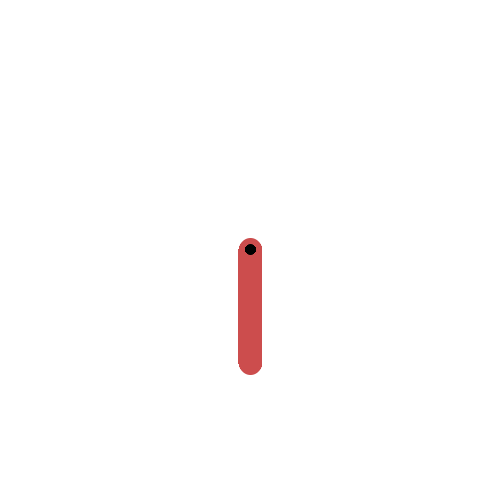

In [8]:
from rltools import load_checkpoint_from_path
policy = load_checkpoint_from_path("checkpoint.h")
evaluate(policy)

`load_checkpoint_from_path` compiles the stored `checkpoint.h` into a Python module to make it accessible.

# Embedding Exported Checkpoints

The following example shows how the exported `checkpoint.h` can be embedded into C/C++ code for inference:

```cpp
#define RL_TOOLS_DEVICES_DISABLE_REDEFINITION_DETECTION // To enable multiple different devices to be imported in the same file. We use the ARM device for inference (which is generic and also works on the CPU) and a CPU device for `rlt::print`
#include <rl_tools/operations/arm.h>
#include <rl_tools/operations/cpu.h> // just for `rlt::print`
#include <rl_tools/nn/layers/dense/operations_arm/opt.h> // optimized inference operations for dense layers (for ARM)
#include <rl_tools/nn/layers/standardize/operations_generic.h>
#include <rl_tools/nn/layers/sample_and_squash/operations_generic.h>
#include <rl_tools/nn_models/mlp/operations_generic.h>
#include <rl_tools/nn_models/mlp_unconditional_stddev/operations_generic.h>
#include <rl_tools/nn_models/sequential/operations_generic.h>

#include "../../pendulum_ppo_checkpoint.h" // The example training scripts just dump the model file into the working directory, hence the `../../`. Modify this to wherever you have your checkpoint.

namespace rlt = rl_tools; // For brevity

using DEVICE = rlt::devices::DefaultARM;
using DEVICE_PRINT = rlt::devices::DefaultCPU;
using TI = DEVICE::index_t; // Index type
using T = policy::MODEL::T; // Floating point type (use the one defined in the exported model)
constexpr TI INPUT_DIM = policy::MODEL::INPUT_DIM;
constexpr TI OUTPUT_DIM = policy::MODEL::OUTPUT_DIM;
constexpr TI BATCH_SIZE = 15;
constexpr TI SEED = 1337;

int main(){
    // Buffer for holding intermediate values during the forward pass (depends on the structure of the model, hence)
    decltype(policy::module)::Buffer<BATCH_SIZE, rlt::MatrixStaticTag> buffer; // Passing `rlt::MatrixStaticTag` to signal that the buffer should be allocated on the stack
    rlt::MatrixStatic<rlt::matrix::Specification<T, TI, BATCH_SIZE, policy::MODEL::INPUT_DIM>> input; // Statically allocated (stack)
    rlt::MatrixStatic<rlt::matrix::Specification<T, TI, BATCH_SIZE, policy::MODEL::OUTPUT_DIM>> output; // Statically allocated (stack)

    DEVICE device;
    DEVICE_PRINT device_print;
    auto rng = rlt::random::default_engine(device.random, SEED); // to fill the input with random values. Some models or layers also require sampling, hence it is passed in `rlt::evaluate` as well

    rlt::randn(device, input, rng);
    rlt::evaluate(device, policy::module, input, output, buffer, rng); // Uses the `policy::module` (defined in the exported checkpoint) to evaluate the input and fill the output. The buffer and rng are used depending on the model architecture of `policy::module`
    rlt::log(device_print, device_print.logger, "Result: "); // Print the result (BATCH_SIZE x OUTPUT_DIM matrix)
    rlt::print(device_print, output);

    return 0;
}
```
You should modify the `#include "../../pendulum_ppo_checkpoint.h"` to match the location of your exported checkpoint. 

To compile you can simply use e.g.:
```bash
clang++ -std=c++17 test.cpp -I../../rltools/external/rl_tools/include && ./a.out
```

You can modify the `-I...` to match the `.../rl_tools/include` directory (wherever you cloned RLtools). 

Note that this example is meant to be run on a PC, by removing the `#include <rl_tools/operations/cpu.h>`, `DEVICE_PRINT`, and the `rlt::print` you should be able to compile it into a firmware for ARM or other microcontrollers (like ESP32). To use the `output` in your downstream application, you can access the values through e.g. `float v0 = rlt::get(output, 0, 0)` (row and column respectively).